In [2]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kalman_filter_with_input
importlib.reload(kalman_filter_with_input)

KalmanFilter = kalman_filter_with_input.KalmanFilter

## Aufgabe 1

### Simulate High Data

Parameter

In [78]:
Ts = 0.5  # [s]
N = 30  # samples
ACC_CONST = 20  # [m/s^2]
GRAVITY_ACCEL = 9.81  # [m/s^2]
sigma_u = 0 # 0.1  # [m/s^2]
sigma_height = 50  # [m]

In [79]:
# Initialization
v_true = np.zeros(N)
y_true = np.zeros(N)
y_meas = np.zeros(N)

# Simulate trajectory
u_control = (ACC_CONST + sigma_u * np.random.randn(N)) - GRAVITY_ACCEL

for n in range(N-1):
    y_true[n+1] = y_true[n] + v_true[n]*Ts + 0.5*u_control[n]*(Ts**2)
    v_true[n+1] = v_true[n] + u_control[n]*Ts

y_meas = y_true + np.random.randn(N) * sigma_height
t = np.arange(N)

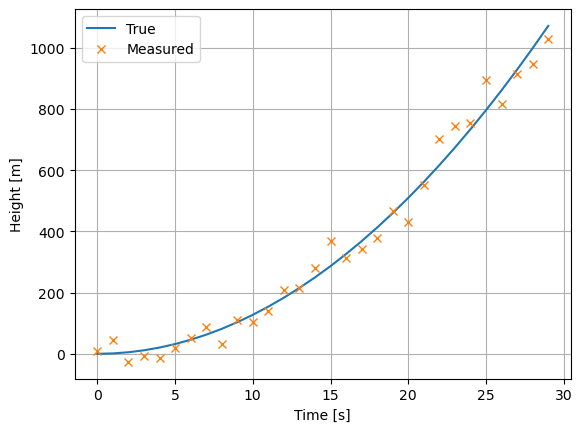

In [80]:
# Visualize
plt.figure(1)
plt.plot(t, y_true)
plt.plot(t, y_meas,'x')
plt.xlabel("Time [s]")
plt.ylabel("Height [m]")
plt.legend(["True", "Measured"])
plt.grid(True)
plt.show()

In [81]:
# Save data
np.savez("measurement_data", y_meas=y_meas, Ts=Ts, sigma_u=sigma_u, sigma_height=sigma_height, ACC_CONST=ACC_CONST, GRAVITY_ACCEL=GRAVITY_ACCEL)
np.savez("groundtruth_data", y_true=y_true, v_true=v_true, Ts=Ts)

### Run Kalman-Filter

Load Data

In [82]:
meas_data = np.load("measurement_data.npz")
y_meas = meas_data['y_meas']
Ts = meas_data['Ts']
ACC_CONST = meas_data['ACC_CONST']
g0 = meas_data['GRAVITY_ACCEL']
N = len(y_meas)

Initialize

In [83]:
# State space model
A = np.array([[1, Ts],
              [0, 1]]) # Beispiel 3 aus der Vorlesung

B = np.array([(Ts**2)/2, Ts]) 
C = np.array([1, 0])

Q = (meas_data['sigma_u']**2) * np.array([[0.25*Ts**4, 0.5*Ts**3], [0.5*Ts**3, Ts**2]])
R = meas_data['sigma_height']**2

# Initialize Kalman filter and state estimates
xhat = np.zeros((2,N))
P = np.zeros((2,2,N))
u = np.ones(N)*(ACC_CONST - g0)
Kgain = np.zeros((2,N))
x0 = np.array([0,0])
P0 = 1e3*np.eye(2)
kf = KalmanFilter(A, B, C, Q, R, x0, P0)


Filtering

In [84]:
for k in range(N):
    kf.kalman_update(y_meas[k], u[k])
    xhat[:,k] = kf.x
    P[:,:,k] = kf.P
    Kgain[:,k] = kf.K

### Results

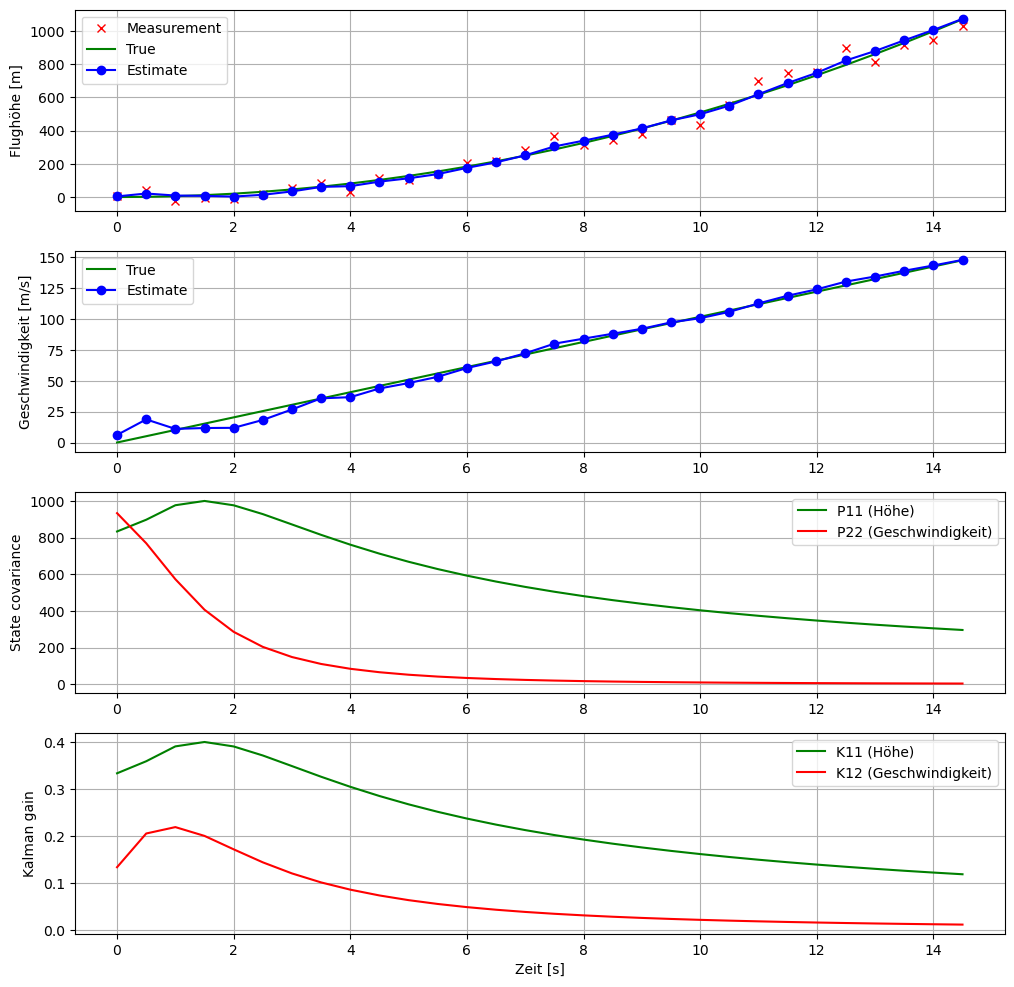

In [85]:
groundtruth_data = np.load("groundtruth_data.npz")
t = np.arange(N)*Ts

plt.figure(1, figsize=(12,12))
plt.subplot(411)
plt.plot(t, y_meas, 'xr')
plt.plot(t, groundtruth_data['y_true'], '-g')
plt.plot(t, xhat[0,:], '-bo')
plt.legend([ 'Measurement', 'True', 'Estimate'])
plt.ylabel("Flughöhe [m]")
plt.grid(True)

plt.subplot(412)
plt.plot(t, groundtruth_data['v_true'], '-g')
plt.plot(t, xhat[1,:], '-bo')
plt.legend(['True', 'Estimate'])
plt.ylabel("Geschwindigkeit [m/s]")
plt.grid(True)

plt.subplot(413)
plt.plot(t, P[0,0,:], '-g')
plt.plot(t, P[1,1,:], '-r')
plt.ylabel("State covariance")
plt.legend(['P11 (Höhe)', 'P22 (Geschwindigkeit)'])
plt.grid(True)

plt.subplot(414)
plt.plot(t, Kgain[0,:], '-g')
plt.plot(t, Kgain[1,:], '-r')
plt.xlabel("Zeit [s]")
plt.ylabel("Kalman gain")
plt.legend(['K11 (Höhe)', 'K12 (Geschwindigkeit)'])
plt.grid(True)

plt.show()

## Aufgabe 2

### Load Data

In [3]:
data_accel = pd.read_csv('Accelerometer.csv', delimiter=';')
data_press = pd.read_csv('Pressure.csv', delimiter=';')

t_accel = data_accel['Time (s)']
acceleration = data_accel['Acceleration z (m/s^2)']

t_press = data_press['Time (s)']
pressure = data_press['Pressure (hPa)']

[]

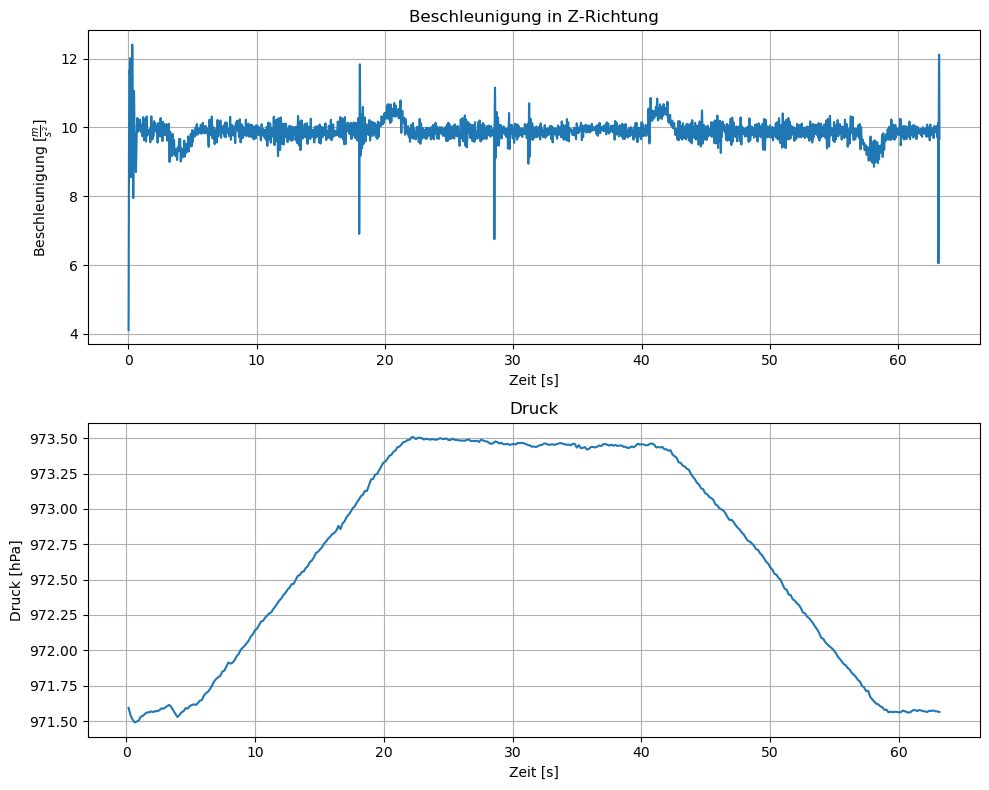

In [4]:
plt.figure(2, figsize=(10,8))
plt.subplot(211)
plt.plot(t_accel, acceleration)
plt.title('Beschleunigung in Z-Richtung')
plt.ylabel(r'Beschleunigung [$\frac{m}{s^2}$]')
plt.xlabel('Zeit [s]')
plt.grid(True)

plt.subplot(212)
plt.plot(t_press, pressure)
plt.title('Druck')
plt.ylabel(r'Druck [hPa]')
plt.xlabel('Zeit [s]')
plt.grid(True)

plt.tight_layout()
plt.plot()

### Schätzung durch Integration ?

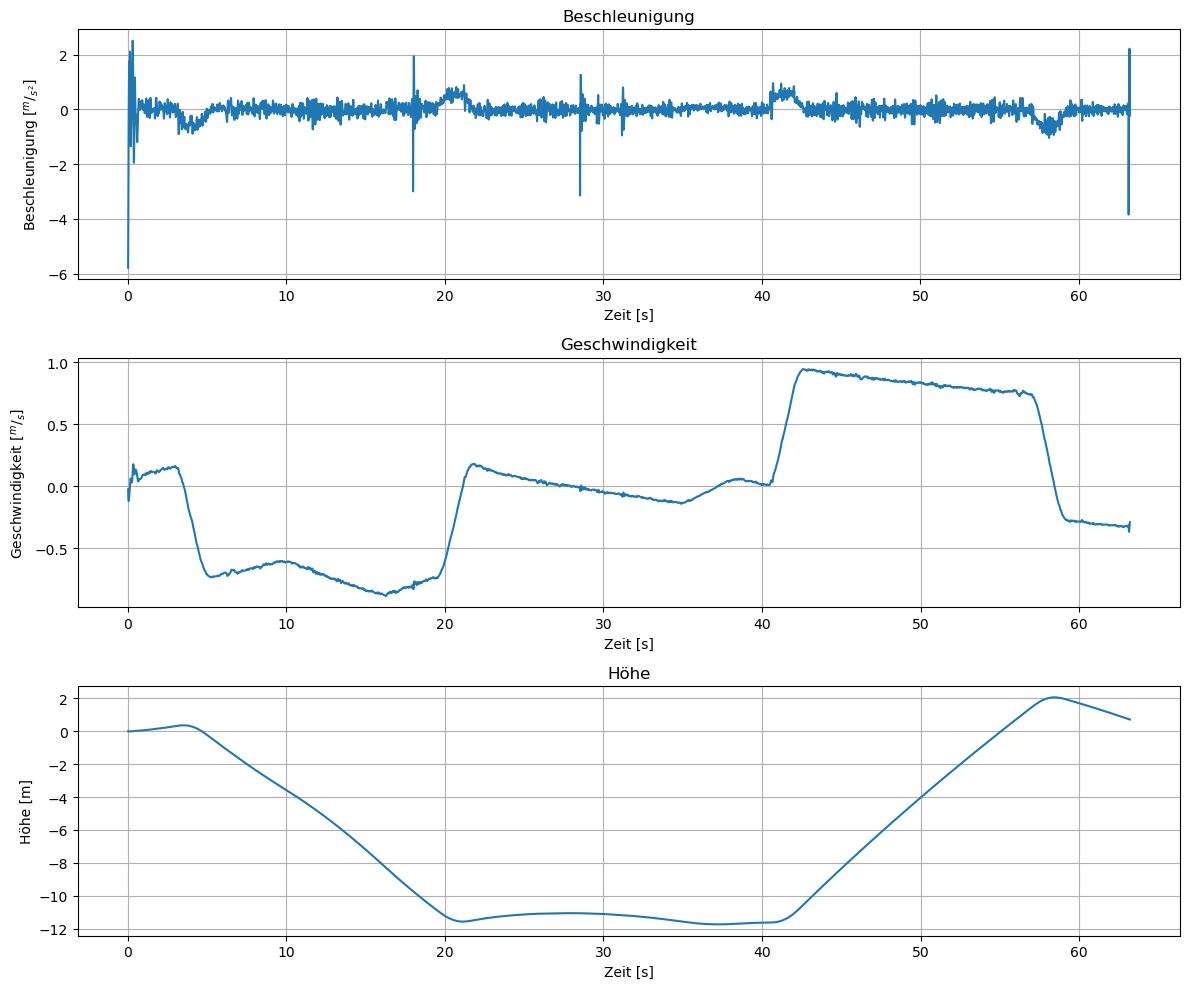

In [34]:
v = np.cumsum(np.diff(t_accel)*(acceleration[:-1]-np.median(acceleration)))
h = np.cumsum(np.diff(t_accel)*v)
 
plt.figure(3, figsize=(12,10))
plt.subplot(311)
plt.plot(t_accel,acceleration-np.median(acceleration))
plt.title('Beschleunigung')
plt.xlabel('Zeit [s]')
plt.ylabel(r'Beschleunigung [$^m/_{s^2}$]')
plt.grid(True)

plt.subplot(312)
plt.plot(t_accel[:-1],v)
plt.title('Geschwindigkeit')
plt.xlabel('Zeit [s]')
plt.ylabel(r'Geschwindigkeit [$^m/_s$]')
plt.grid(True)

plt.subplot(313)
plt.plot(t_accel[:-1],h)
plt.title('Höhe')
plt.xlabel('Zeit [s]')
plt.ylabel(r'Höhe [m]')
plt.grid(True)

plt.tight_layout()
plt.show()

### Schätzung mit Kalmann Filter